# 2022-05-13 • Network conntest Roxin params

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin (see previous nb).

In [5]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    to_record = [1, 801],
);
# dumps(p)

## Run sim

In [6]:
s = cached(sim, [p.sim]);

Uncached output:
```
Running simulation: 100%|███████████████████████████████| Time: 0:11:31
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\sim\b77ff1c19d7f1e33.jld2` … done (0.7 s)
```

In [7]:
function augment_simdata(s, p)
    num_spikes_per_neuron = length.(s.spike_times)
    spike_rates           = num_spikes_per_neuron ./ p.sim.general.duration
    return (; s..., num_spikes_per_neuron, spike_rates)
end;

In [8]:
s = augment_simdata(s,p);

In [9]:
import PyPlot

In [10]:
using VoltoMapSim.Plot

In [17]:
tlim = @. 3minutes + [0,10]seconds;
tlim = [0,10]seconds;

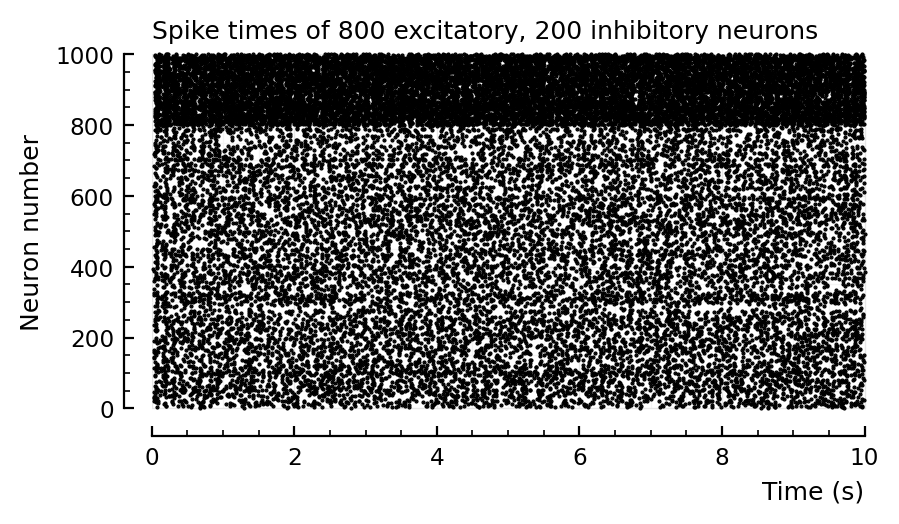

In [18]:
rasterplot(s.spike_times; tlim);

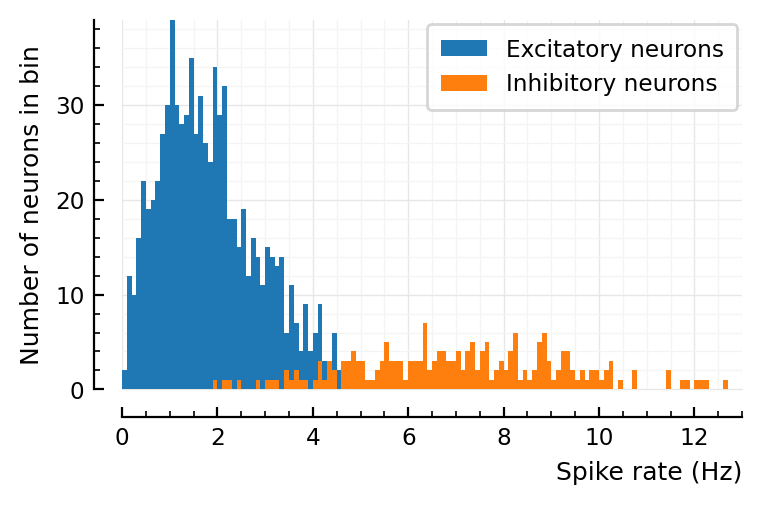

In [19]:
histplot_fr(s.spike_rates);

In [55]:
# VI_sigs = add_VI_noise(s.voltage_traces, p);

In [56]:
# ax = plotsig(s.timesteps, VI_sigs[1] / mV; tlim, label="VI signal");
# ax = plotsig(s.timesteps, s.signals[1] / mV; tlim, ax, label="Membrane voltage")
# legend(ax, reorder=[2=>1])
# set(ax, xlabel="Simulation time (s)", ylabel="mV");

## Connection test

In [19]:
analyzed_neuron = 1;  # neuron ID

In [20]:
v = s.signals[analyzed_neuron].v;

In [21]:
input_neurons = s.input_neurons[analyzed_neuron]
length(input_neurons)

36

In [22]:
input_neurons_by_type = CVec(exc=[n for n in input_neurons if s.neuron_type[n] == :exc],
                             inh=[n for n in input_neurons if s.neuron_type[n] == :inh])

ComponentVector{Int64}(exc = [11, 33, 66, 70, 101, 132, 136, 139, 145, 169  …  446, 447, 516, 565, 597, 629, 681, 710, 766, 800], inh = [829, 831, 894, 897, 902, 908, 914, 922, 928, 988])

In [23]:
length(input_neurons_by_type.exc),
length(input_neurons_by_type.inh)

(26, 10)

In [24]:
unconnected_neurons = [n for n in s.neuron_IDs if n ∉ input_neurons && n != analyzed_neuron];
length(unconnected_neurons)

963

Highest firing inputs

In [59]:
sort!(collect(zip(input_neurons, s.spike_rates[input_neurons])), by = tup -> tup[2])

36-element Vector{Tuple{Int64, Float64}}:
 (337, 0.152)
 (33, 0.29)
 (136, 0.623)
 (516, 0.683)
 (800, 0.832)
 (70, 0.833)
 (66, 0.94)
 (169, 0.958)
 (303, 1.2)
 (145, 1.26)
 (629, 1.31)
 (101, 1.32)
 (418, 1.41)
 ⋮
 (922, 3.41)
 (565, 4.46)
 (908, 4.69)
 (312, 4.84)
 (829, 6.09)
 (897, 7.96)
 (831, 8.8)
 (914, 8.82)
 (928, 8.94)
 (902, 10.2)
 (894, 11.5)
 (988, 11.8)

In [64]:
highest_firing_inputs = sort(input_neurons, by = id -> s.spike_rates[id], rev = true);
highest_firing_inputs[1]

988

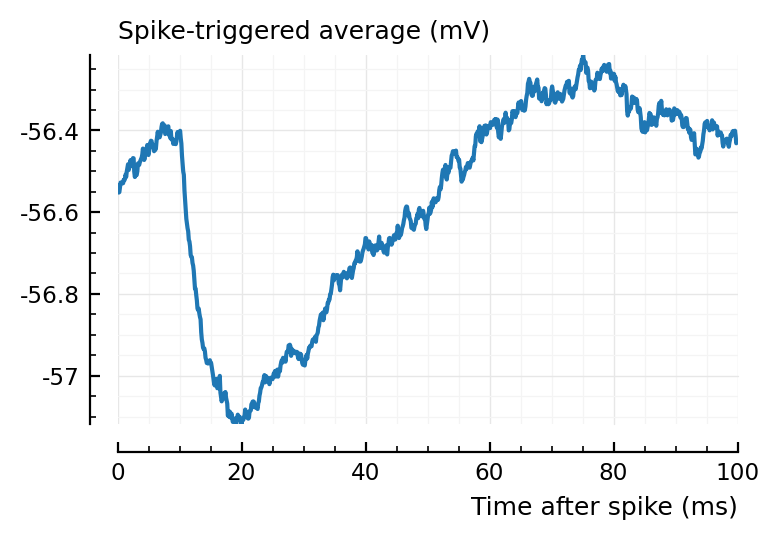

In [132]:
plotSTA(v, s.spike_times[highest_firing_inputs[1]], p);

In [69]:
highest_firing_exc_inputs = [n for n in highest_firing_inputs if s.neuron_type[n] == :exc]
highest_firing_inh_inputs = [n for n in highest_firing_inputs if s.neuron_type[n] == :inh]
highest_firing_exc_inputs[1], highest_firing_inh_inputs[1]

(312, 988)

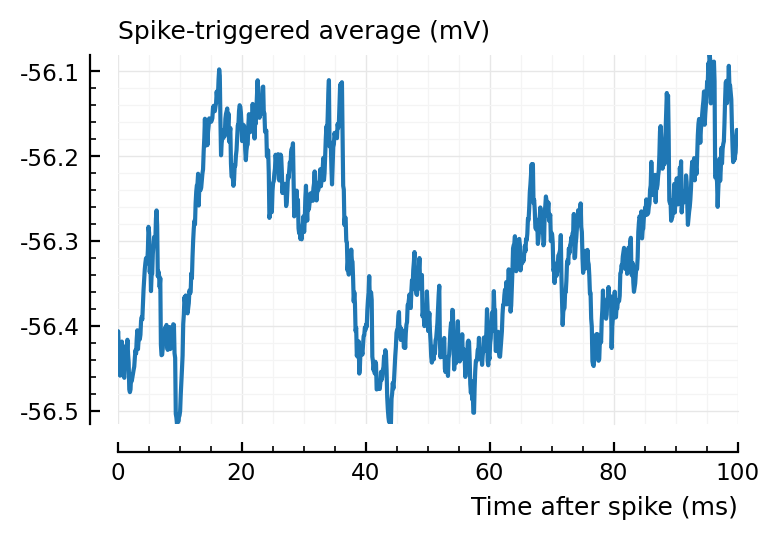

In [76]:
plotSTA(v, s.spike_times[highest_firing_exc_inputs[1]], p);

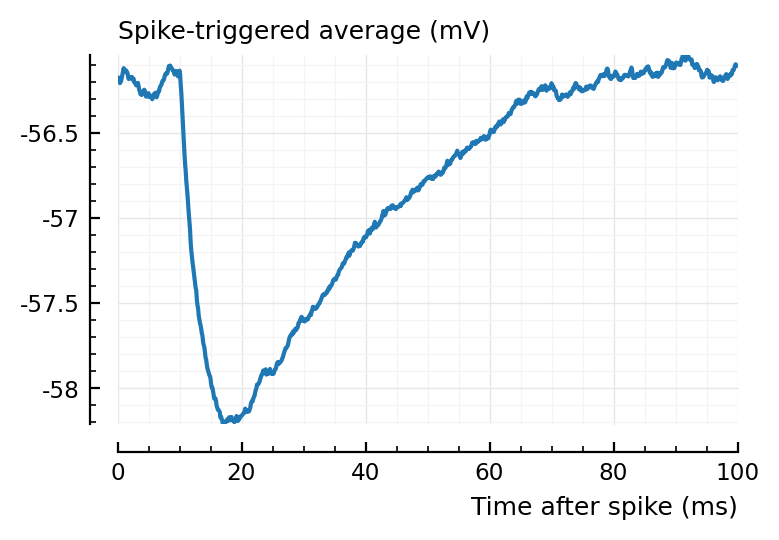

In [91]:
plotSTA(v, s.spike_times[highest_firing_inh_inputs[2]], p);

I→E STAs are much cleaner. This is likely bc their synaptic weights are 36x larger.

In [89]:
spiketrains_by_type = (;
    conn = (;
        exc = [s.spike_times[n] for n in input_neurons_by_type.exc],
        inh = [s.spike_times[n] for n in input_neurons_by_type.inh],
    ),
    unconn = [s.spike_times[n] for n in unconnected_neurons],
);

In [71]:
perf = evaluate_conntest_perf(v, spiketrains_by_type, p);

LoadError: UndefVarError: spiketrains_by_type not defined

(see bottom of notebook)

All inhibitory detected! :D

This is cause I changed reversal potential from -65 to -80 mV; and cause 36x stronger synapses (both following Roxin).

----

Check whether detected exc inputs are the highest firing ones.

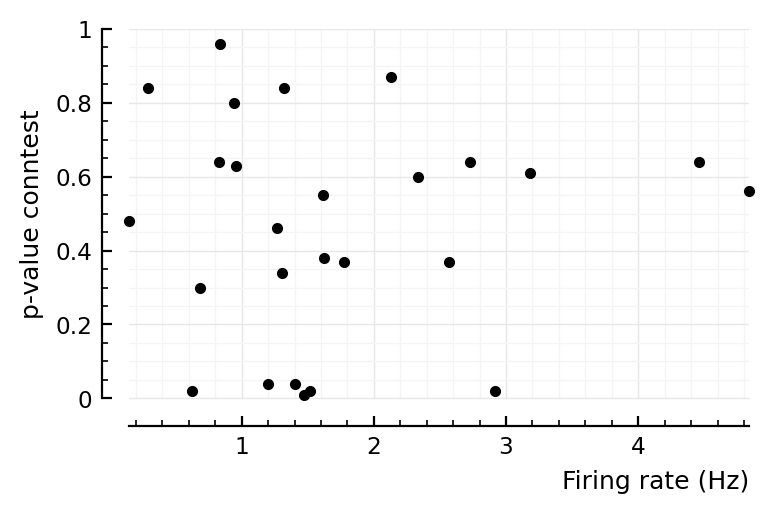

In [109]:
fr = Float64[]
pval = Float64[]
for (i,n) in enumerate(input_neurons_by_type.exc)
    push!(fr, spike_rates[n])
    push!(pval, perf.p_values.conn.exc[i])
end
ax = plot(fr, pval, "k.", clip_on = false, xlabel="Firing rate (Hz)", ylabel="p-value conntest", ylim=(0,1));

No, doesn't seem like it.

Plot STA of detected exc inputs.

In [120]:
show(perf.p_values.conn.exc)

Any[0.01, 0.84, 0.8, 0.96, 0.84, 0.6, 0.02, 0.87, 0.46, 0.63, 0.38, 0.04, 0.56, 0.48, 0.02, 0.04, 0.37, 0.64, 0.3, 0.64, 0.02, 0.34, 0.61, 0.55, 0.37, 0.64]

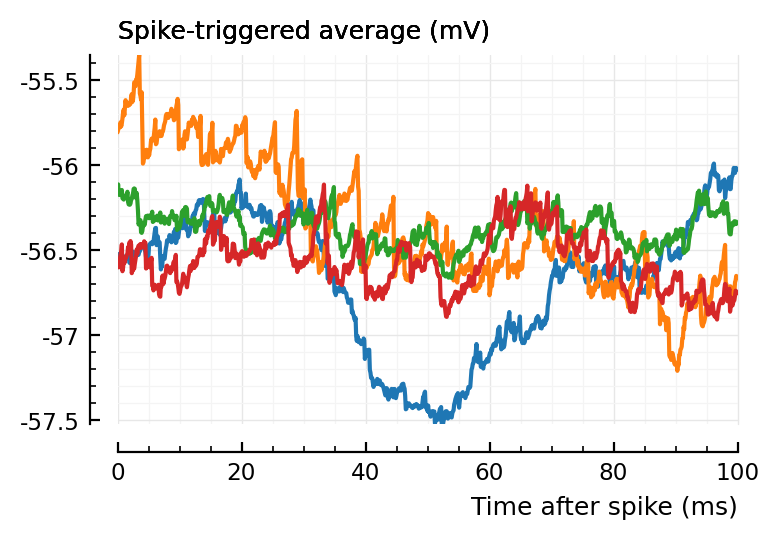

In [131]:
N = length(input_neurons_by_type.exc)
for i in sortperm(perf.p_values.conn.exc)[[1,2,N-1,N]]
    plotSTA(v, s.spike_times[input_neurons_by_type.exc[i]], p)
end

blue and orange are the two lowest p-values, green and red the highest (worst, undetected).

## Test connections to an inhibitory neuron

In [11]:
function neuron_info(n, s, p)
    # Return exc and inh inputs, with the highest firing first.
    # n = neuron ID
    # s = augmented simdata
    # p = ExperimentParams
    input_neurons = sort(s.input_neurons[n], by = m -> s.spike_rates[m], rev = true)
    exc_inputs = [m for m in input_neurons if s.neuron_type[m] == :exc]
    inh_inputs = [m for m in input_neurons if s.neuron_type[m] == :inh]
    unconnected_neurons = [m for m in s.neuron_IDs if m ∉ input_neurons]
    spiketrains = (
        conn = (
            exc = [s.spike_times[m] for m in exc_inputs],
            inh = [s.spike_times[m] for m in inh_inputs],
        ),
        unconn = [s.spike_times[m] for m in unconnected_neurons],
    )
    return (;
        exc_inputs,
        inh_inputs,
        unconnected_neurons,
        spiketrains,
        v = s.signals[n].v,
        num_inputs = (exc = length(exc_inputs), inh = length(inh_inputs)),
    )
end;

In [12]:
ni = neuron_info(801, s, p);

In [13]:
ni.num_inputs

(exc = 21, inh = 10)

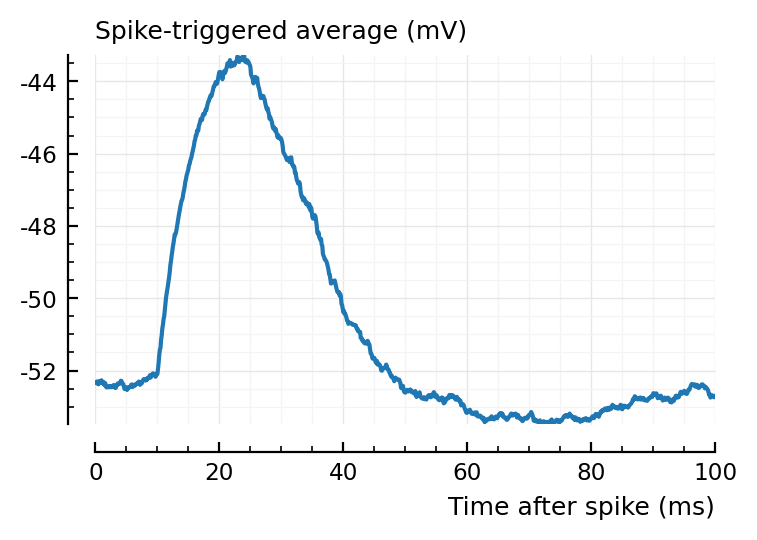

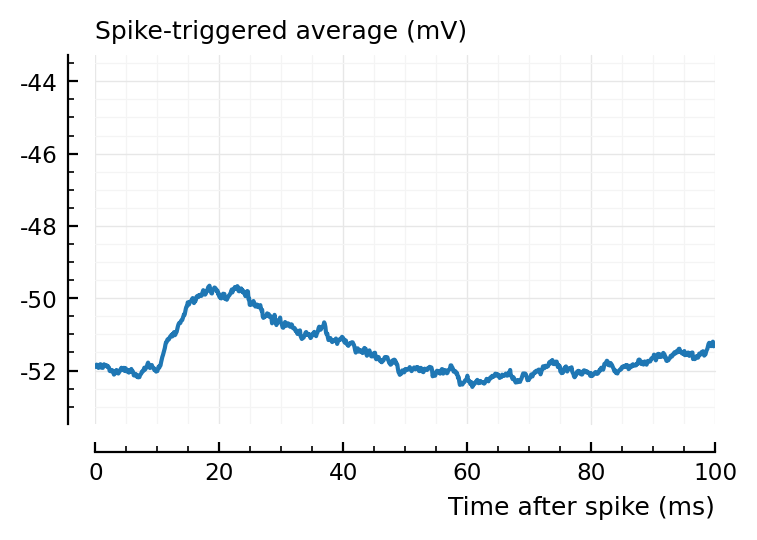

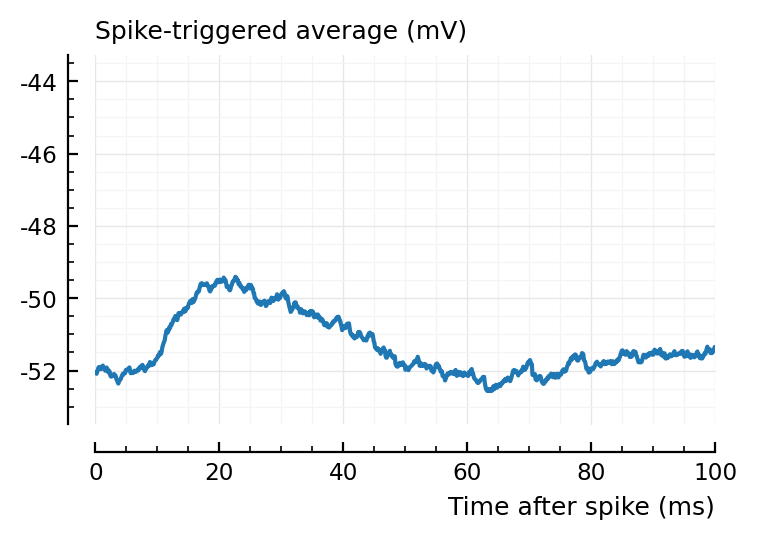

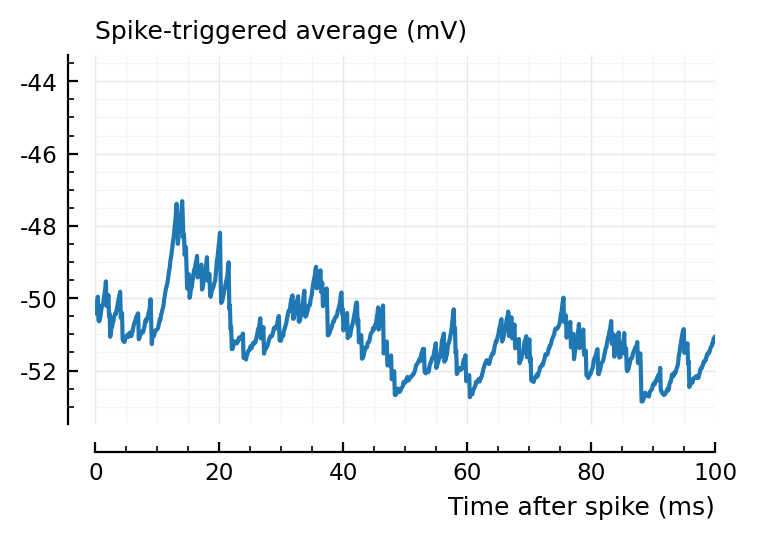

In [90]:
ax1 = plotSTA(ni.v, ni.spiketrains.conn.exc[1], p);
ylim = ax1.get_ylim()
plotSTA(ni.v, ni.spiketrains.conn.exc[2], p; ylim);
plotSTA(ni.v, ni.spiketrains.conn.exc[3], p; ylim);
plotSTA(ni.v, ni.spiketrains.conn.exc[end], p; ylim);

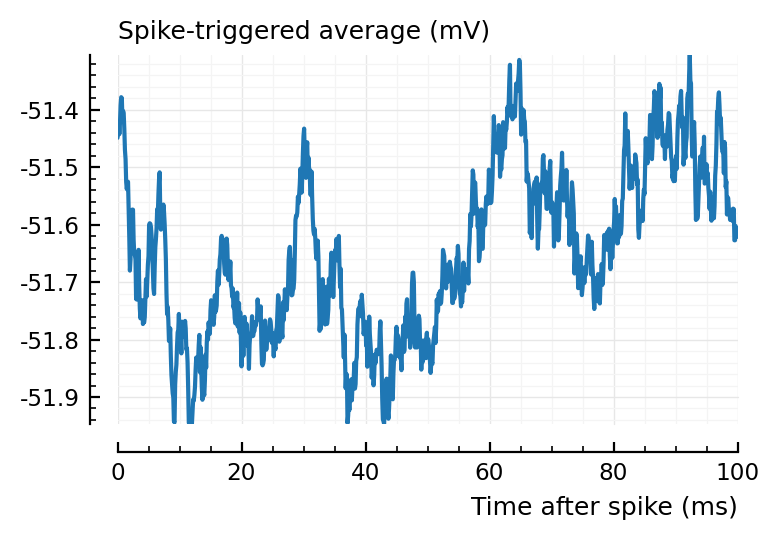

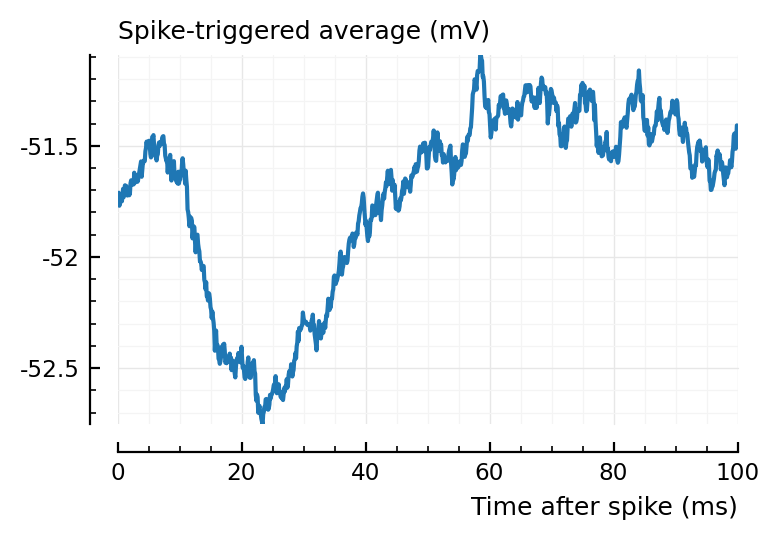

In [91]:
ax1 = plotSTA(ni.v, ni.spiketrains.conn.inh[1], p);
ax2 = plotSTA(ni.v, ni.spiketrains.conn.inh[2], p);

In [14]:
perf = evaluate_conntest_perf(ni.v, ni.spiketrains, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:289m


In [60]:
perf.detection_rates

(TPR_exc = 0.714, TPR_inh = 0.9, FPR = 0.05)

### Use `neuron_info` for neuron 1

In [62]:
ni1 = neuron_info(1, s, p);

In [63]:
ni1.num_inputs

(exc = 26, inh = 10)

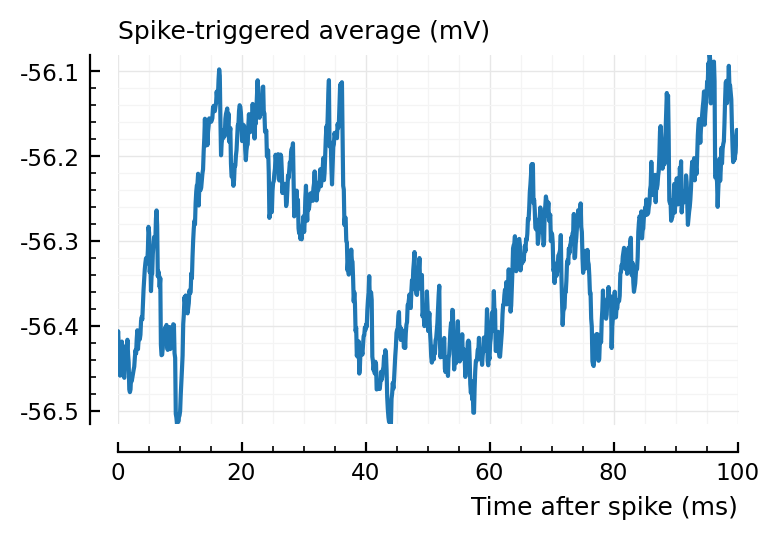

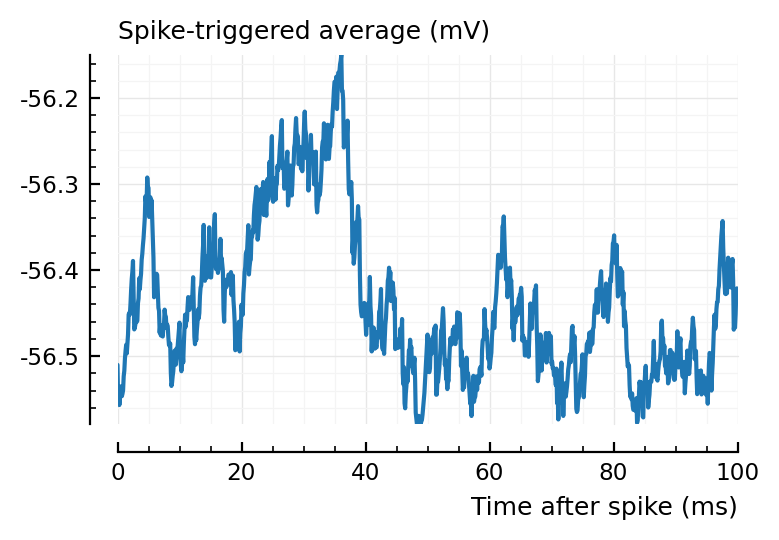

In [99]:
for i in 1:2
    plotSTA(ni1.v, ni1.spiketrains.conn.exc[i], p)
end

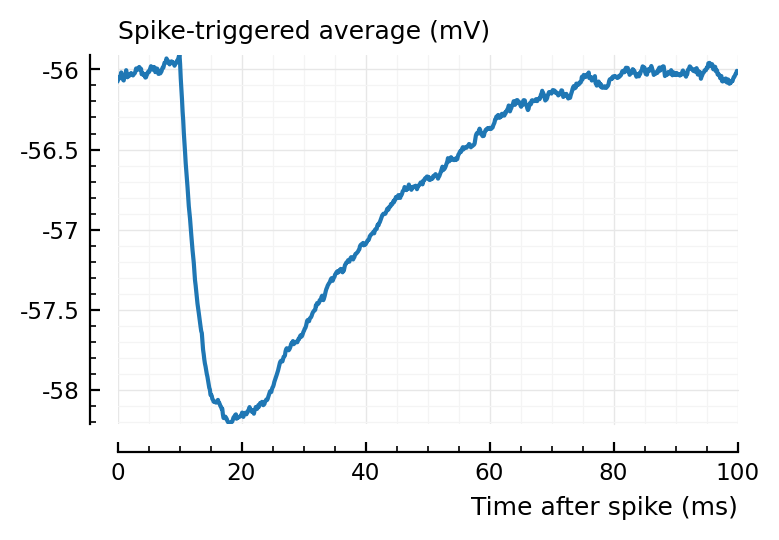

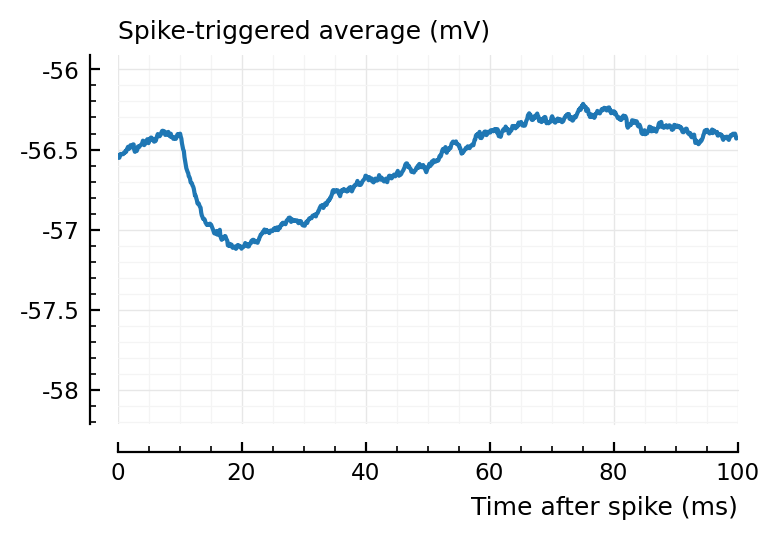

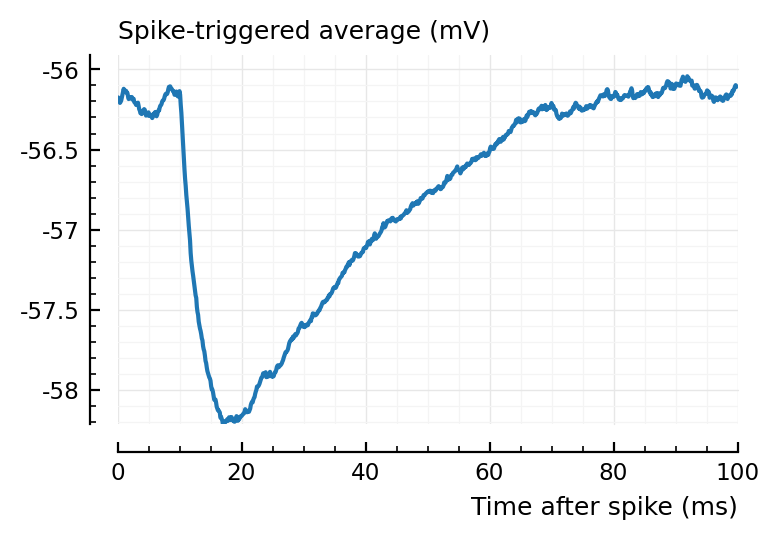

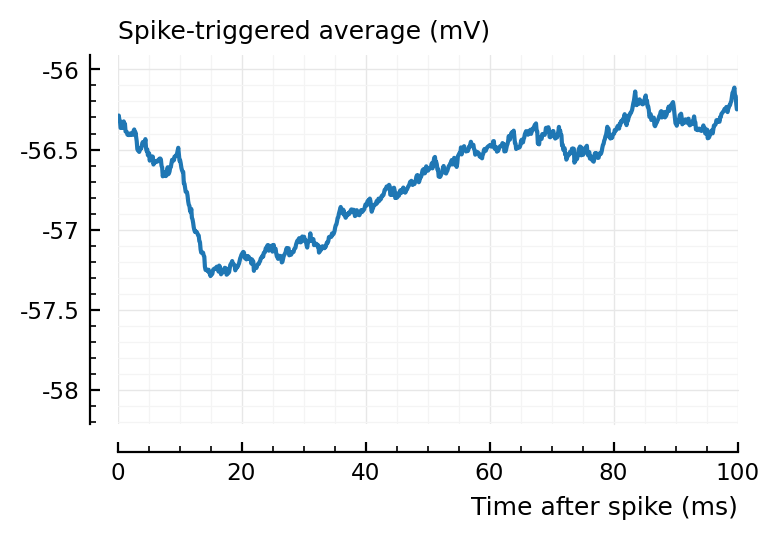

In [70]:
ax1 = plotSTA(ni1.v, ni1.spiketrains.conn.inh[3], p);
ylim = ax1.get_ylim()
plotSTA(ni1.v, ni1.spiketrains.conn.inh[1], p; ylim);
plotSTA(ni1.v, ni1.spiketrains.conn.inh[2], p; ylim);
plotSTA(ni1.v, ni1.spiketrains.conn.inh[end], p; ylim);

In [72]:
perf = evaluate_conntest_perf(ni1.v, ni1.spiketrains, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:31


In [74]:
perf.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)